In [4]:
using Revise

In [5]:
using Distributed
procs_to_use = 10

if nprocs() <= procs_to_use
    addprocs(procs_to_use-nprocs())
end

@everywhere using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples,
    ProgressMeter

@everywhere @consts begin
    λ = 606e-9
    Γ = 2π * 8.3e6
    m = @with_unit 59 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

[ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



### Calculate transition dipole moments

In [6]:
@everywhere begin
    include("define_CaF_states.jl")
    X_states, A_states = define_CaOH_states()
    states = [X_states; A_states[1:4]]
    d = tdms_between_states(states, states)

    states[14].E += 4.8e6
    states[15].E += 4.8e6
    states[16].E += 4.8e6
end
;

### Define Zeeman Hamiltonian

In [7]:
@everywhere include("define_Zeeman_Hamiltonian.jl")
;

### Run simulation

In [8]:
@everywhere function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Zeeman_Hx = p.extra_data.Zeeman_Hx
    Zeeman_Hy = p.extra_data.Zeeman_Hy
    
    τ_bfield = p.sim_params.B_ramp_time / (1/Γ)
    scalar = t/τ_bfield
    scalar = min(scalar, 1.0)
    
    gradient_x = -scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_y = +scalar * p.sim_params.B_gradient * 1e2 / k / 2
    gradient_z = -scalar * p.sim_params.B_gradient * 1e2 / k
    
    Bx = gradient_x * r[1] + p.sim_params.B_offset[1]
    By = gradient_y * r[2] + p.sim_params.B_offset[2]
    Bz = gradient_z * r[3] + p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i] + Bx * Zeeman_Hx.re[i] + By * Zeeman_Hy.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i] + Bx * Zeeman_Hx.im[i] + By * Zeeman_Hy.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [9]:
@everywhere extra_data = MutableNamedTuple(
    Zeeman_Hx = Zeeman_x_mat,
    Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat
)
;

In [10]:
@everywhere function solve_stochastic(prob)
    p, dψ, ψ, δt, ts, save_every = prob
    
    save_length = floor(Int, ts[end] / save_every)
    ψs = [Vector{ComplexF64}(undef, length(ψ)) for _ ∈ 1:save_length]
    saved = 1
    
    @showprogress for i ∈ eachindex(ts)
        t = ts[i]
        evolve_fixed_timestep!(p, dψ, ψ, t, δt)

        if (t - saved * save_every) >= 0
            ψs[saved] .= ψ
            saved += 1
        end
        
    end
    return (prob, ψs)
end
;

In [50]:
@everywhere begin
    
    Isat = π*h*c*Γ/(3λ^3) / 10
    I = 5.8 # mW/cm^2, for each beam
    s = I / Isat
    
    s1 = 1.0 * 3.0s / (1 + 1.4)
    s2 = 0s
    s3 = 0s
    s4 = 1.4 * 3.0s / (1 + 1.4)
    s5 = 0s
    
    detuning = 23.8
    δ1 = -0.7
    δ2 = +0.0
    δ3 = +0.0
    δ4 = +0.0
    δ5 = +0.0
    
#     # CaF Λ-cooling
#     Isat = π*h*c*Γ/(3λ^3) / 10
#     I = 5.8 # mW/cm^2, for each beam
#     s = I / Isat
    
#     s1 = 1.00 * 2s / (1.00 + 0.92)
#     s2 = 0s
#     s3 = 0s
#     s4 = 0.92 * 2s / (1.00 + 0.92)
#     s5 = 0s
    
#     detuning = 30.0
#     δ1 = +0.0
#     δ2 = +0.0
#     δ3 = +0.0
#     δ4 = +0.0
#     δ5 = +0.0
    
end
;

In [51]:
@everywhere sim_params = MutableNamedTuple(
    
    pol_imbalance = 0.,
    s_imbalance = (0., 0., 0.),
    retro_loss = 0.,
    off_center = (0, 0, 0, 0, 0, 0) .* 1e-3,
    pointing_error = (0, 0, 0, 0, 0, 0),

    B_gradient = -27.0,
    B_ramp_time = 1e-6,
    B_offset = (0., 0., 0.),
    
    s_ramp_time = 1e-6,
    s_ramp_to = 1.0,

    s1 = s1,
    s2 = s2,
    s3 = s3,
    s4 = s4,
    s5 = s5,
    Δ1 = detuning + δ1,
    Δ2 = detuning + δ2,
    Δ3 = detuning + δ3,
    Δ4 = detuning + δ4,
    Δ5 = detuning + δ5,
    pol1_x = [1,0,0],
    pol2_x = [0,0,1],
    pol3_x = [1,0,0],
    pol4_x = [0,0,1],
    pol5_x = [1,0,0],
    
    dt = 3e-10 / (1/Γ)

)
;

### Define lasers

In [52]:
@everywhere begin
    include("define_lasers.jl")
    # include("define_lasers_extra.jl")
    lasers = define_lasers(
        states,
        sim_params.s1,
        sim_params.s2,
        sim_params.s3,
        sim_params.s4,
        sim_params.s5,
        sim_params.Δ1,
        sim_params.Δ2,
        sim_params.Δ3,
        sim_params.Δ4,
        sim_params.Δ5,
        sim_params.pol1_x,
        sim_params.pol2_x,
        sim_params.pol3_x,
        sim_params.pol4_x,
        sim_params.pol5_x,
        sim_params.s_ramp_time,
        sim_params.s_ramp_to,
        sim_params.pol_imbalance,
        sim_params.s_imbalance,
        sim_params.retro_loss,
        sim_params.off_center,
        sim_params.pointing_error
    )
end
;

In [53]:
@everywhere begin
    t_start = 0.0
    t_end   = 2e-3
    t_span  = (t_start, t_end) ./ (1/Γ)

    n_states = length(states)
    n_excited = 4

    particle = Particle()
    particle.r = (0, 0, 0) ./ (1/k)
    particle.v = (0, 0, 0) ./ (Γ/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0

    diffusion_constant = 0.020
    
    δt = 3e-10 / (1/Γ)
    ts = t_span[1]:δt:t_span[2]

    p = schrodinger_stochastic(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; 
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H, diffusion_constant=diffusion_constant)

    ψ = deepcopy(p.ψ)
    dψ = deepcopy(p.ψ)

    save_every = t_span[2] / 200
    
    prob = (p, dψ, ψ, δt, ts, save_every)    
end

@time (prob, ψs) = solve_stochastic(prob)
;

Progress:  17%|████████                                 |  ETA: 0:01:35

LoadError: InterruptException:

In [54]:
x_trajectories = [real(ψ[n_states + n_excited + 1]) for ψ in ψs] ./ k*1e3
y_trajectories = [real(ψ[n_states + n_excited + 2]) for ψ in ψs] ./ k*1e3
z_trajectories = [real(ψ[n_states + n_excited + 3]) for ψ in ψs] ./ k*1e3
x_velocities = [real(ψ[n_states + n_excited + 4]) for ψ in ψs] .* (Γ/k)
y_velocities = [real(ψ[n_states + n_excited + 5]) for ψ in ψs] .* (Γ/k)
z_velocities = [real(ψ[n_states + n_excited + 6]) for ψ in ψs] .* (Γ/k)
velocities = [[vx,vy,vz] for (vx,vy,vz) ∈ zip(x_velocities, y_velocities, z_velocities)]

# excited_population = real.([sum(conj(u[i]) * u[i] for i ∈ 13:16) for u in plot_us])
;

### Run simulation for multiple particles in parallel

In [ ]:
# @everywhere begin
#     n_molecules = 10
#     probs = [deepcopy(prob) for i ∈ 1:n_molecules]
# end
n_molecules = 10
probs = [deepcopy(prob) for i ∈ 1:n_molecules]
sols = pmap(solve_stochastic, probs)
;

In [ ]:
times = 1:floor(t_span[2] / 1000)
;

In [ ]:
x_trajectories = Array{Vector{Float64}}(fill([], n_molecules))
y_trajectories = Array{Vector{Float64}}(fill([], n_molecules))
z_trajectories = Array{Vector{Float64}}(fill([], n_molecules))
x_velocities = Array{Vector{Float64}}(fill([], n_molecules))
y_velocities = Array{Vector{Float64}}(fill([], n_molecules))
z_velocities = Array{Vector{Float64}}(fill([], n_molecules))

photons_scattered = zeros(n_molecules)
excited_populations = Array{Vector{Float64}}(fill([], n_molecules))
times = Array{Vector{Float64}}(fill([], n_molecules))

for i ∈ 1:n_molecules
    sol_u = sols[i][2]
    sol_t = sols[i][2]
    
    x_trajectories[i] = [x_trajectories[i]; [real(u[n_states + n_excited + 1]) for u in sol_u] ./ k*1e3]
    y_trajectories[i] = [y_trajectories[i]; [real(u[n_states + n_excited + 2]) for u in sol_u] ./ k*1e3]
    z_trajectories[i] = [z_trajectories[i]; [real(u[n_states + n_excited + 3]) for u in sol_u] ./ k*1e3]
    
    x_velocities[i] = [x_velocities[i]; [real(u[n_states + n_excited + 4]) for u in sol_u] ./ (k/Γ)]
    y_velocities[i] = [y_velocities[i]; [real(u[n_states + n_excited + 5]) for u in sol_u] ./ (k/Γ)]
    z_velocities[i] = [z_velocities[i]; [real(u[n_states + n_excited + 6]) for u in sol_u] ./ (k/Γ)]
    
    photons_scattered[i] = sols[i][1][1].n_scatters
    
#     excited_population = real.([sum(conj(u[i]) * u[i] for i ∈ 13:16) for u in sol_u])
    
#     excited_populations[i] = excited_population
    
    # times[i] = sol_t .* (1/Γ)
end

trajectories = [
    [[x[1],x[2],x[3]] for x ∈ zip(x_trajectories[i], y_trajectories[i], z_trajectories[i])] 
    for i ∈ 1:n_molecules
    ]
;

In [ ]:
photons_scattered ./ t_end

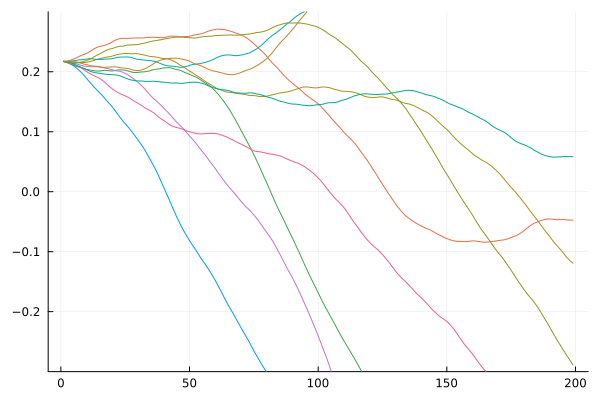

In [45]:
plot(z_trajectories, legend=nothing, ylim=(-0.3,0.3))

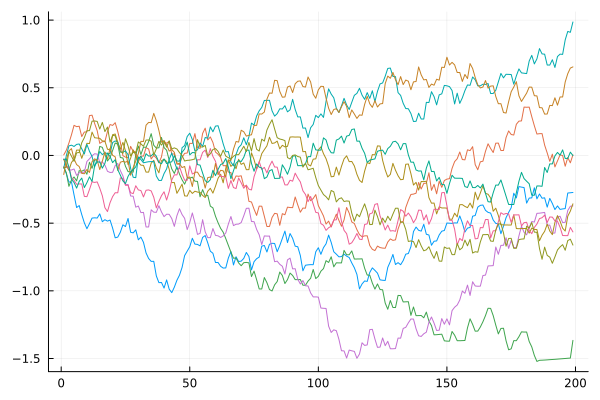

In [46]:
plot(z_velocities, legend=nothing)

In [47]:
# function survived(i, t_end, times)
#     return t_end ≈ times[i][end]
# end

# survived_molecules = [i for i ∈ 1:n_molecules if survived(i, t_end, times)]

# survived_times = times[survived_molecules]

# survived_x_trajectories = x_trajectories[survived_molecules]
# survived_y_trajectories = y_trajectories[survived_molecules]
# survived_z_trajectories = z_trajectories[survived_molecules]

# survived_x_velocities = x_velocities[survived_molecules]
# survived_y_velocities = y_velocities[survived_molecules]
# survived_z_velocities = z_velocities[survived_molecules]
# ;

In [48]:
# Γ .* mean(excited_populations[i] for i ∈ survived_molecules) |> plot

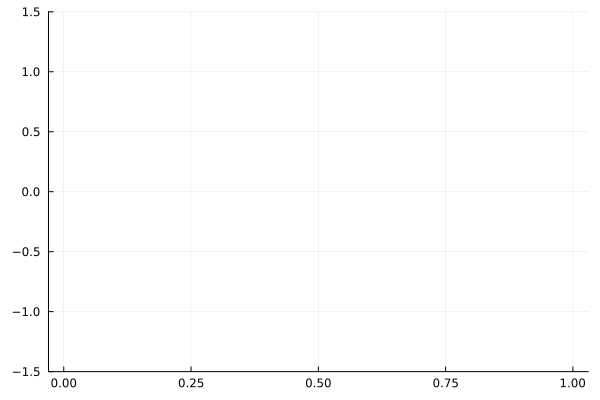

In [49]:
lim = 1.5
plot()
for i ∈ 1:n_molecules
    plot!(times[i] .* 1e3, z_trajectories[i], legend=nothing, ylim=(-lim, lim))
end
plot!()

In [395]:
function cloud_size(time, times, x_trajectories, y_trajectories, z_trajectories)
    xs = []
    ys = []
    zs = []
    for i ∈ eachindex(times)
        time_idx = searchsortedfirst(times[i], time)
        if length(times[i]) > time_idx
            push!(xs, x_trajectories[i][time_idx])
            push!(ys, y_trajectories[i][time_idx])
            push!(zs, z_trajectories[i][time_idx])
        end
    end
    return (std(xs) * std(ys) * std(zs))^(1/3)
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2))
end

function cloud_size_fitted(xs)

    hist_data = fit(Histogram, xs, -0.4:0.01:0.4)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(Gaussian, v, fv, [0.5, 0., 5])
    σ, x0, A = v_fit.param
    
    histogram!(xs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return σ
end
;

3-element Vector{Float64}:
 -0.01063320090415347
 -0.002340617882037578
 37.596093212618776

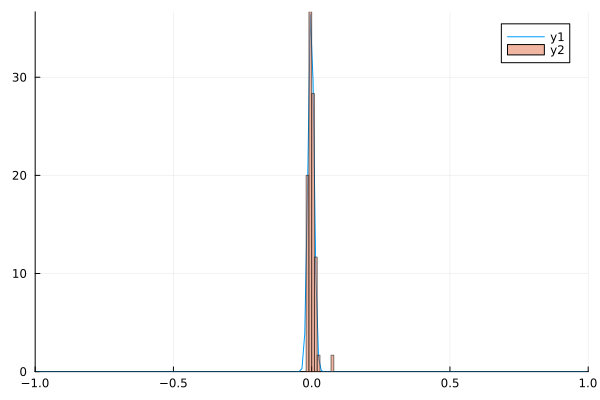

In [396]:
xs = [x_trajectories[i][end] for i ∈ (1:n_molecules)]
ys = [y_trajectories[i][end] for i ∈ (1:n_molecules)]
zs = [z_trajectories[i][end] for i ∈ (1:n_molecules)]

hist_data = fit(Histogram, zs, -1.0:0.01:1.0)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

v_fit = curve_fit(Gaussian, v, fv, [0.05, 0., 5])
σ, x0, A = v_fit.param

display(v_fit.param)
plot(v, Gaussian(v, v_fit.param))
histogram!(zs, bins=hist_data.edges, xlim=(-1.0, 1.0), alpha=0.5, normalize=true)

In [397]:
# plot_ts = 0:0.1e-3:4.9e-3
# cloud_sizes = [cloud_size(t, 
#         times[survived_molecules], 
#         x_trajectories[survived_molecules],
#         y_trajectories[survived_molecules],
#         z_trajectories[survived_molecules])
#     for t ∈ plot_ts]
# ;

In [398]:
survived_molecules = 1:n_molecules
cloud_sizes_x_fitted = [cloud_size_fitted([traj[i] for traj ∈ x_trajectories]) for i ∈ eachindex(x_trajectories[survived_molecules][1])]
cloud_sizes_y_fitted = [cloud_size_fitted([traj[i] for traj ∈ y_trajectories]) for i ∈ eachindex(y_trajectories[survived_molecules][1])]
cloud_sizes_z_fitted = [cloud_size_fitted([traj[i] for traj ∈ z_trajectories]) for i ∈ eachindex(z_trajectories[survived_molecules][1])]
cloud_sizes_fitted = (abs.(cloud_sizes_x_fitted) .* abs.(cloud_sizes_y_fitted) .* abs.(cloud_sizes_z_fitted)).^(1/3)
;

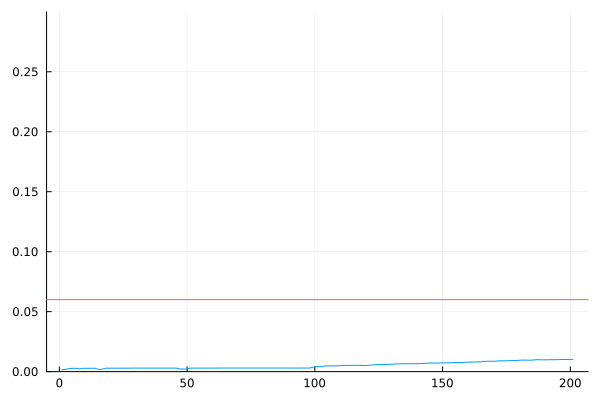

In [399]:
plot(cloud_sizes_fitted, ylim=(0,0.3), legend=nothing)
hline!([0.06])

3-element Vector{Float64}:
 0.000694052685918946
 0.9867490006374621
 3.8836102526055725e-5

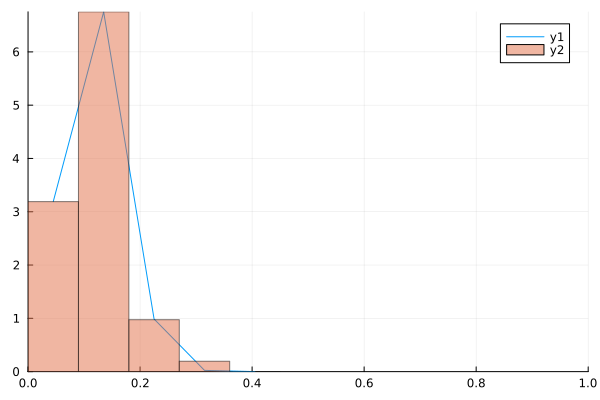

In [404]:
velocities = [sqrt.(x_velocities[i].^2 .+ y_velocities[i].^2 .+ z_velocities[i].^2) for i ∈ 1:n_molecules];

function maxwell_boltzmann(v, p)
    v0, A, T = p
    return A * ((m/(2π*kB*T))^(3/2) * 4π) .* (v .- v0) .^2 .* exp.((v .- v0) .^2 .* (-m / (2*kB*T)))
end

# take velocities from t = 5 ms to t = 8 ms
vs = [[v[end-10:end] for v ∈ velocities]]
vs = vec(hcat(vs...))
vs = vec(hcat(vs...))

hist_data = fit(Histogram, vs, 0.0:0.09:0.5)
hist_data.isdensity = true
v = collect(hist_data.edges[1])
dv = v[2]-v[1]
v = v[1:end-1] .+ dv/2
fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

plot(hist_data)

v_fit = curve_fit(maxwell_boltzmann, v, fv, [0, 4, 10e-6])
v0, A, T = v_fit.param

display(v_fit.param)
plot(v, maxwell_boltzmann(v, v_fit.param))
histogram!(vs, bins=hist_data.edges, xlim=(0.0, 1.0), alpha=0.5, normalize=true)

In [405]:
T * 1e6

38.836102526055726

In [375]:
function fit_temperature(vs)

    hist_data = fit(Histogram, vs, 0.0:0.1:2.0)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    histogram(hist_data)
    
    v_fit = curve_fit(maxwell_boltzmann, v, fv, [4, 100e-6])
    A, T = v_fit.param
    
    # histogram!(vs, bins=hist_data.edges, xlim=(-0.3, 0.3), alpha=0.5, normalize=true)
    
    return T
end
;

In [376]:
fit_temperature([v[end] for v ∈ velocities]) * 1e6

LoadError: BoundsError: attempt to access 2-element Vector{Float64} at index [3]

## With diffusion

In [408]:
@everywhere begin
    t_start = 0.0
    t_end   = 2e-4
    t_span  = (t_start, t_end) ./ (1/Γ)

    n_states = length(states)
    n_excited = 4

    particle = Particle()
    particle.r = (0, 0, 0) ./ (1/k)
    particle.v = (0, 0, 0) ./ (Γ/k)
    ψ₀ = zeros(ComplexF64, n_states)
    ψ₀[1] = 1.0

    diffusion_constant = 0.0
    
    δt = 1e-10 / (1/Γ)
    ts = t_span[1]:δt:t_span[2]

    p = schrodinger_stochastic_diffusion(particle, states, lasers, d, ψ₀, m/(ħ*k^2/Γ), n_excited; 
        sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, update_H_and_∇H=update_H_and_∇H)

    ψ = deepcopy(p.ψ)
    dψ = deepcopy(p.ψ)

    save_every = t_span[2] / 200
    
    prob = (p, dψ, ψ, δt, ts, save_every)
end

# @time ψs = solve_stochastic(prob)
;

In [409]:
@everywhere function solve_stochastic_diffusion(prob)
    p, dψ, ψ, δt, ts, save_every = prob
    
    save_length = floor(Int, ts[end] / save_every) + 1
    ψs = [Vector{ComplexF64}(undef, length(ψ)) for _ ∈ 1:save_length]
    saved = 0
    
    @showprogress for i ∈ eachindex(ts)
        t = ts[i]

        if (t - saved * save_every) >= 0
            ψs[saved+1] .= ψ
            saved += 1
        end
        
        evolve_fixed_timestep_diffusion!(p, dψ, ψ, t, δt)
        
    end
    return (prob, ψs)
end
;

In [410]:
# @time (prob, ψs) = solve_stochastic_diffusion(prob)
# ;

In [411]:
prob[1].sum_diffusion_x / prob[1].n_scatters

NaN

In [412]:
prob[1].sum_diffusion_y / prob[1].n_scatters

NaN

In [413]:
prob[1].sum_diffusion_z / prob[1].n_scatters

NaN

In [414]:
n_molecules = 60
probs = [deepcopy(prob) for i ∈ 1:n_molecules]
sols = pmap(solve_stochastic_diffusion, probs)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57

Excessive output truncated after 557329 bytes.